In [1]:
from os.path import join, dirname, abspath
import mol_example
from chirho_diffeqpy.load_julia_env import LOADED_PACKAGES as LOADED_JULIA_PACKAGES, load_julia_env
from chirho_diffeqpy import DiffEqPy, ODEProblemWrapper, LogAtExtraDomains
from diffeqpy import de
import numpy as np
import torch
import matplotlib.pyplot as plt
from mol_example.load_and_render_jl_file import load_and_render_jl_file
from chirho.dynamical.handlers import LogTrajectory
from chirho.dynamical.ops import simulate

# DEBUG
from chirho_diffeqpy.internals import interpolate_solution, pre_broadcast_initial_state

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


In [2]:
# Load julia environment and prep access to julia files.
jl = load_julia_env()
julia_code_dir = dirname(abspath(mol_example.__file__))
# LOADED_JULIA_PACKAGES

# Define PDE and Discretize to ODE in Julia

In [3]:
load_and_render_jl_file(
    jl=jl,
    file_path=join(julia_code_dir, 'dirichlet_heat.jl')
)

┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154


┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154


In [4]:
ode_prob = jl.ode_prob

In [5]:
np.array(ode_prob.u0).shape

(99,)

In [6]:
np.array(ode_prob.p).shape

(1,)

# Solve ODE Directly Using SciML API (via python calls).

In [7]:
tspan = np.linspace(0.0, 1.0, 100)
sol = de.solve(ode_prob, de.Tsit5(), saveat=tspan)

In [8]:
xx = torch.linspace(0.0, 1.0, 99)  # TODO HACK this just "happens" to be the same as the julia-side discretization. See below.

In [9]:
# TODO WIP one gotcha is that xx here HAS to align with the initial state xx. Because it will be used as the initial state
#  of any subsequent chunks of the simulation.
# I.e. this is kinda meh. we'd really like to recover exactly what the discretization is that the initial state needs to be defined on.
# Then we can 
#  1) require that the user provide an appropriate initial state
#  2) flatten/unflatten as desired and make sure that it lines up with the discretization.
#  3) already know what additional discretized domains we need to interpolate into.

# Still though, we do need to make sure that we can flatten this all out into something that the julia function can interoperate with.
with LogAtExtraDomains(xx):
    trajectory = interpolate_solution(sol, tspan)

# TODO btw somewhere we need to make clear that time must always be the first dimension of any solution. I.e. the julia definitions
#  need to follow this convention.

Andy fix the column-major row-major reshaping issues here.


In [10]:
np_trajectory = np.array(trajectory)

In [11]:
np_trajectory.shape

(100, 99)

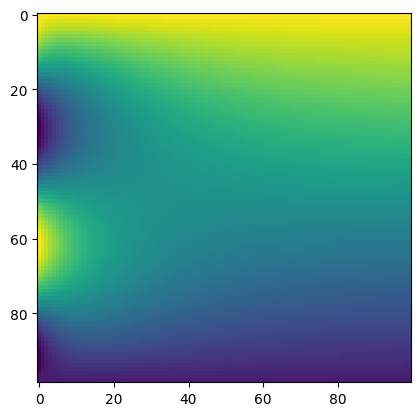

In [12]:
plt.imshow(np_trajectory.T)

# Solve with Chirho API

In [13]:
# Wrap the problem so that we can slot it in as the dynamics in the chirho api.
heat_dynamics = ODEProblemWrapper(ode_prob)
initial_state = dict(
    u=torch.tensor(np_trajectory[0])
)
atemp_params = dict(
    diffusivity=torch.tensor(0.1)
)

In [14]:
# Testing
_ = pre_broadcast_initial_state(heat_dynamics, initial_state, atemp_params)

In [15]:
solver = DiffEqPy(alg=de.Tsit5())

In [47]:
with solver, LogTrajectory(times=torch.linspace(0.0, 1.0, 101)) as lt, LogAtExtraDomains(xx):
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    102-element Vector{Float64}:
│     0.0
│     0.01
│     0.02
│     0.03
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.


In [34]:
torch_trajectory = lt.trajectory

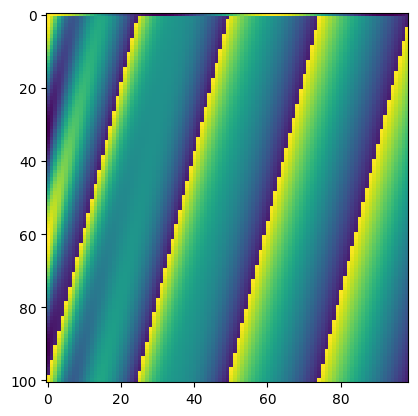

In [35]:
plt.imshow(torch_trajectory['u'].T.detach())